## OBJECTIVE 

Develop an intelligent facial emotion analysis system, that captures and understands real-time emotional states of users from visual cues and dynamically adapts content (e.g., advertisements, multimedia, user interface elements) to resonate with and enhance the user experience based on their current mood.

### Data Info

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

Categories (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral). The training set consists of 28,709 examples and the public test set consists of 7,178 examples.

Data retrived from Kaggle: https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.13.0


### Data loading and processing

In [3]:
data_dir = 'archive/train' #training data directory

# Initialize the image generator with augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split=0.2 #80% for training
)
# Initialize a second generator for validation
val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  #20% for validation
)

In [4]:
# Generate training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',  # Specify that this is the training subset
    shuffle= True
)

# Generate validation data
validation_generator = val_gen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',  # Specify that this is the validation subset
    shuffle= True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


### Visualize some images 

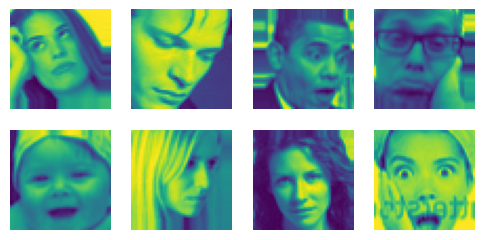

In [5]:
# Function to display augmented images with no labels
def display_images(dataset):
    images, _ = next(dataset)
    plt.figure(figsize=(6, 6))  # Increase the size to better fit 16 images
    for i in range(8):  # Displaying the first 16 images from the batch
        ax = plt.subplot(4, 4, i + 1)  # Creating a 4x4 grid to display 16 images
        plt.imshow(images[i])  # Show the ith image
        plt.axis("off")
    plt.show()

# Now, call the function with your dataset
display_images(train_generator)

### (CNN) Model Building 

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Define the input layer with the shape (48, 48, 1)
inputs = Input(shape=(48,48,1))

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
# Add a batch normalization layer
x = BatchNormalization()(x)

# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
# Add a second batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
# Add a third batch normalization layer
x = BatchNormalization()(x)
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
# Add a fourth batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
# Add a fifth batch normalization layer
x = BatchNormalization()(x)
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
# Add a sixth batch normalization layer
x = BatchNormalization()(x)
# Add a max pooling layer with 2x2 pool size
x = MaxPooling2D(pool_size=(2, 2))(x)
# Add a dropout layer with 0.25 dropout rate
x = Dropout(0.25)(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)
# Add a dense layer with 256 neurons and relu activation function
x = Dense(256, activation='relu')(x)
# Add a seventh batch normalization layer
x = BatchNormalization()(x)
# Add a dropout layer with 0.5 dropout rate
x = Dropout(0.5)(x)
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
outputs = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0     

In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    loss='categorical_crossentropy',  # Since it's a multi-class classification problem
    metrics=['accuracy'] 
)

### Model Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
359/359 [==============================] - 70s 194ms/step - loss: 2.7946 - accuracy: 0.1818 - val_loss: 1.9120 - val_accuracy: 0.2364
Epoch 2/100
359/359 [==============================] - 73s 205ms/step - loss: 2.4159 - accuracy: 0.2193 - val_loss: 1.7807 - val_accuracy: 0.3327
Epoch 3/100
359/359 [==============================] - 75s 210ms/step - loss: 2.2223 - accuracy: 0.2544 - val_loss: 1.7104 - val_accuracy: 0.3485
Epoch 4/100
359/359 [==============================] - 76s 212ms/step - loss: 2.0876 - accuracy: 0.2820 - val_loss: 1.6645 - val_accuracy: 0.3644
Epoch 5/100
359/359 [==============================] - 76s 212ms/step - loss: 1.9802 - accuracy: 0.3073 - val_loss: 1.5400 - val_accuracy: 0.4198
Epoch 6/100
359/359 [==============================] - 74s 207ms/step - loss: 1.8919 - accuracy: 0.3262 - val_loss: 1.5766 - val_accuracy: 0.4179
Epoch 7/100
359/359 [==============================] - 76s 212ms/step - loss: 1.8171 - accuracy: 0.3486 - val_loss: 1.5631 -

Epoch 57/100
359/359 [==============================] - 76s 211ms/step - loss: 0.9365 - accuracy: 0.6489 - val_loss: 1.0097 - val_accuracy: 0.6323
Epoch 58/100
359/359 [==============================] - 77s 214ms/step - loss: 0.9270 - accuracy: 0.6547 - val_loss: 1.0095 - val_accuracy: 0.6302
Epoch 59/100
359/359 [==============================] - 77s 213ms/step - loss: 0.9213 - accuracy: 0.6558 - val_loss: 1.0163 - val_accuracy: 0.6271
Epoch 60/100
359/359 [==============================] - 76s 211ms/step - loss: 0.9115 - accuracy: 0.6584 - val_loss: 1.0347 - val_accuracy: 0.6215
Epoch 61/100
359/359 [==============================] - 75s 210ms/step - loss: 0.9104 - accuracy: 0.6615 - val_loss: 1.0457 - val_accuracy: 0.6204
Epoch 62/100
359/359 [==============================] - 74s 207ms/step - loss: 0.9110 - accuracy: 0.6588 - val_loss: 1.0092 - val_accuracy: 0.6293
Epoch 63/100
359/359 [==============================] - 77s 213ms/step - loss: 0.8969 - accuracy: 0.6666 - val_loss: 1

### Model Evaluation

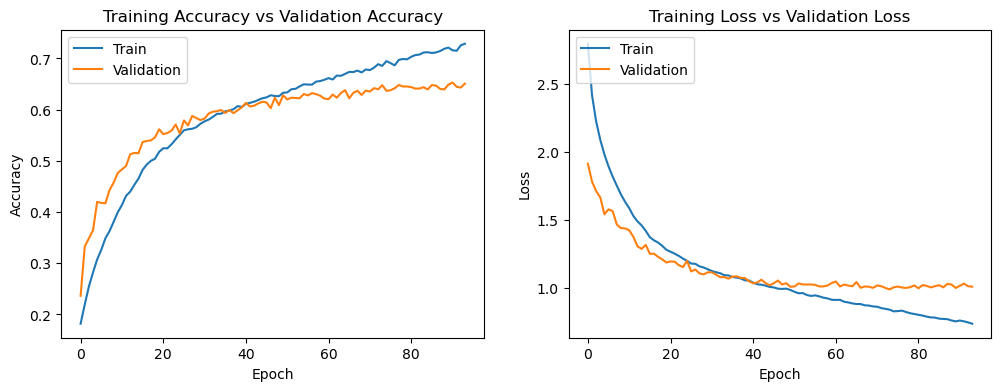

In [9]:
# Evaluating and Visualizing the Model Performance
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
# Save the model
model.save('cnn_model.h5')

/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### VGG16 Model building (Transfer learning)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

In [12]:
#### Preprocess the data for new model

In [15]:
# grayscale image conversion
def custom_grayscale_conversion(x):
    # Convert the RGB image to grayscale using custom method
    grayscale_image = np.mean(x, axis=-1, keepdims=True)
    return grayscale_image

# Create an instance of the ImageDataGenerator with augmentation
generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    preprocessing_function=custom_grayscale_conversion,  # Convert to grayscale
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split=0.2
)

# Instance of the ImageDataGenerator
valid_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    preprocessing_function=custom_grayscale_conversion,  # Convert to grayscale
    validation_split=0.2
)


# traing data (augmented)
batch_size = 64
train_generator_df = generator.flow_from_directory(
    'archive/train',
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='rgb',  # Keep this as RGB even though you're converting to grayscale
    subset='training',
    shuffle= True
)

# validation data
batch_size = 64
val_generator_df = valid_gen.flow_from_directory(
    'archive/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb',  # Keep this as RGB even though you're converting to grayscale
    subset='validation',
    shuffle= True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [16]:
# Initialize the base model
base_model = VGG16(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

base_model.trainable = False  # Freezing the base model layers

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [17]:
# Adding our input and output layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

model2 = Model(base_model.input, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [18]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    loss='categorical_crossentropy',  # Since it's a multi-class classification problem
    metrics=['accuracy'] 
)

In [19]:
# model training
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)
# Train the model
history2 = model2.fit(
    train_generator_df,
    steps_per_epoch=len(train_generator_df),
    epochs=100,
    validation_data=val_generator_df,
    validation_steps=len(val_generator_df),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
359/359 [==============================] - 85s 237ms/step - loss: 2.3628 - accuracy: 0.2036 - val_loss: 1.7705 - val_accuracy: 0.3282
Epoch 2/100
359/359 [==============================] - 85s 237ms/step - loss: 2.0485 - accuracy: 0.2647 - val_loss: 1.7105 - val_accuracy: 0.3534
Epoch 3/100
359/359 [==============================] - 85s 238ms/step - loss: 1.9202 - accuracy: 0.2918 - val_loss: 1.6599 - val_accuracy: 0.3688
Epoch 4/100
359/359 [==============================] - 85s 237ms/step - loss: 1.8486 - accuracy: 0.3053 - val_loss: 1.6212 - val_accuracy: 0.3768
Epoch 5/100
359/359 [==============================] - 85s 237ms/step - loss: 1.7797 - accuracy: 0.3187 - val_loss: 1.6137 - val_accuracy: 0.3782
Epoch 6/100
359/359 [==============================] - 84s 234ms/step - loss: 1.7538 - accuracy: 0.3273 - val_loss: 1.5939 - val_accuracy: 0.3872
Epoch 7/100
359/359 [==============================] - 86s 239ms/step - loss: 1.7349 - accuracy: 0.3302 - val_loss: 1.5818 -

Epoch 57/100
359/359 [==============================] - 92s 257ms/step - loss: 1.5005 - accuracy: 0.4192 - val_loss: 1.5086 - val_accuracy: 0.4170
Epoch 58/100
359/359 [==============================] - 87s 242ms/step - loss: 1.5047 - accuracy: 0.4173 - val_loss: 1.5093 - val_accuracy: 0.4175
Epoch 59/100
359/359 [==============================] - 88s 245ms/step - loss: 1.4990 - accuracy: 0.4215 - val_loss: 1.5104 - val_accuracy: 0.4194
Epoch 60/100
359/359 [==============================] - 99s 276ms/step - loss: 1.4973 - accuracy: 0.4250 - val_loss: 1.5074 - val_accuracy: 0.4180
Epoch 61/100
359/359 [==============================] - 94s 263ms/step - loss: 1.5021 - accuracy: 0.4171 - val_loss: 1.5073 - val_accuracy: 0.4200
Epoch 62/100
359/359 [==============================] - 91s 254ms/step - loss: 1.4915 - accuracy: 0.4218 - val_loss: 1.5091 - val_accuracy: 0.4221
Epoch 63/100
359/359 [==============================] - 91s 252ms/step - loss: 1.4911 - accuracy: 0.4241 - val_loss: 1

In [20]:
# Evaluate the model on the validation data
eval_result = model2.evaluate(val_generator_df)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

90/90 [==============================] - 17s 190ms/step - loss: 1.4955 - accuracy: 0.4311
Validation Loss: 1.4954686164855957, Validation Accuracy: 0.43110957741737366


#### model2 fine tuning

In [33]:
# To unfreeze some layers:
for layer in base_model.layers[-10:]:  # Unfreezing the last 10 layers
    layer.trainable = True

In [34]:
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x15f6dd280> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x289be5640> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x289f28340> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289da83d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x289f0dfd0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x15e4d4130> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289f67160> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x15fe656a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x28a0b9430> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x289bb40a0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x289bc49d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x28983bfd0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x15fe77790> True
<keras.src.la

In [35]:
# Re-compile the model after unfreezing
model2.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),  # A lower learning rate is often used after unfreezing
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# Train the model
history_fine = model2.fit(
    train_generator_df,
    steps_per_epoch=len(train_generator_df),
    epochs=60,
    validation_data=val_generator_df,
    validation_steps=len(val_generator_df),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
359/359 [==============================] - 307s 854ms/step - loss: 1.0744 - accuracy: 0.5997 - val_loss: 1.3231 - val_accuracy: 0.5161
Epoch 2/60
359/359 [==============================] - 315s 877ms/step - loss: 1.0335 - accuracy: 0.6203 - val_loss: 1.2900 - val_accuracy: 0.5283
Epoch 3/60
359/359 [==============================] - 328s 914ms/step - loss: 1.0073 - accuracy: 0.6311 - val_loss: 1.2669 - val_accuracy: 0.5325
Epoch 4/60
359/359 [==============================] - 310s 863ms/step - loss: 0.9755 - accuracy: 0.6448 - val_loss: 1.2682 - val_accuracy: 0.5360
Epoch 5/60
359/359 [==============================] - 301s 838ms/step - loss: 0.9454 - accuracy: 0.6552 - val_loss: 1.2623 - val_accuracy: 0.5433
Epoch 6/60
359/359 [==============================] - 288s 801ms/step - loss: 0.9206 - accuracy: 0.6644 - val_loss: 1.2346 - val_accuracy: 0.5550
Epoch 7/60
359/359 [==============================] - 291s 810ms/step - loss: 0.8961 - accuracy: 0.6788 - val_loss: 1.2351 -

In [37]:
# Save the model
model2.save('vgg16_modelv1.h5')

### Model Testing
Evaluate the models on testing data and compare the results

In [38]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
# Load the trained models
cnn_model = load_model('cnn_model.h5')
vgg16_model = load_model('vgg16_modelv1.h5')

In [40]:
# grayscale image conversion
def custom_grayscale_conversion(x):
    # Convert the RGB image to grayscale using custom method
    grayscale_image = np.mean(x, axis=-1, keepdims=True)
    return grayscale_image

# Grayscale generator
gray_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_grayscale_conversion  # Convert to grayscale
)
# 

# Testing data for Vgg16 model(3 channels)
gray_test_generator = gray_test_datagen.flow_from_directory(
    'archive/test',
    target_size=(48, 48),
    batch_size=6,
    class_mode='categorical',
    color_mode='rgb'
)

Found 7178 images belonging to 7 classes.


In [41]:
## regular generator for our cnn_model
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    'archive/test',
    target_size=(48, 48),
    batch_size=6,
    class_mode='categorical',
    color_mode='grayscale' # images will be in grayscale with shape (48,48,1)
)

Found 7178 images belonging to 7 classes.


In [42]:
# Evaluate the models on the testing dataset
evaluation1 = cnn_model.evaluate(test_generator)
evaluation2 = vgg16_model.evaluate(gray_test_generator)

1197/1197 [==============================] - 41s 34ms/step - loss: 1.1799 - accuracy: 0.5840


In [46]:
# Print evaluation results
print("CNN Model Evaluation")
print("Test Loss:", evaluation1[0])
print("Test Accuracy:", evaluation1[1])
print("\n")
print("VGG16 Model Evaluation")
print("Test Loss:", evaluation2[0])
print("Test Accuracy:", evaluation2[1])

CNN Model Evaluation
Test Loss: 0.9901394844055176
Test Accuracy: 0.646140992641449


VGG16 Model Evaluation
Test Loss: 1.1798694133758545
Test Accuracy: 0.584006667137146


### Model predictions

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

In [48]:
# extract a face from an image
def extract_face_from_image(image_path, output_size=(48, 48)):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load the pre-trained Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If a face is detected, extract the face
    if len(faces) > 0:
        x, y, w, h = faces[0]  # Use the first detected face
        face = image[y:y+h, x:x+w]
        
        # Resize the face image to the output size
        face = cv2.resize(face, output_size)
        
        # Save or return the face image
        face_output_path = image_path.split('.')[0] + '_face.jpg'
        cv2.imwrite(face_output_path, face)
        return face_output_path  # Return the path to the saved face image

# Call the function with the image path
extracted_face_path = extract_face_from_image('girl-smile.jpeg')


In [49]:
# Load the image file, resizing it to the dimensions required by the models (48x48)
img_path = extracted_face_path  # image path
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')  # Use 'grayscale' for the CNN model
# Convert the image to an array
img_array = image.img_to_array(img)
# Rescale the image in the same way as the training data
img_array /= 255.0
# Add a batch dimension
img_array = np.expand_dims(img_array, axis=0)

In [50]:
img_array.shape

(1, 48, 48, 1)

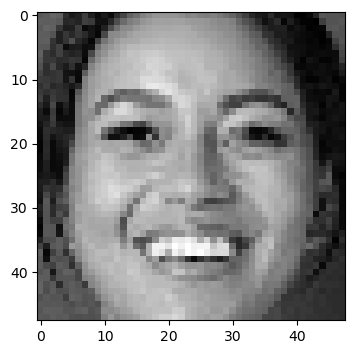

In [51]:
# Squeeze img_array to remove single-dimensional entries
squeezed_img_array = np.squeeze(img_array)
# Now you can display the image
plt.figure(figsize=(4,4))
plt.imshow(squeezed_img_array, cmap='gray')
plt.show()

In [52]:
# Define class names as appeared during training
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Predict with the CNN model
predictions_cnn = cnn_model.predict(img_array)

# Predict with the VGG16 model (vgg16_model is expecting RGB even though it's grayscale)
# For VGG16, since the model is trained on RGB, convert grayscale to "fake RGB" by repeating the grayscale channel
img_array_vgg = np.repeat(img_array, 3, axis=-1)
predictions_vgg16 = vgg16_model.predict(img_array_vgg)

1/1 [==============================] - 0s 61ms/step


In [53]:
# Get the predicted class indices
predicted_class_cnn = np.argmax(predictions_cnn, axis=1)
predicted_class_vgg16 = np.argmax(predictions_vgg16, axis=1)

# Map the predicted class indices to class names
predicted_label_cnn = class_names[predicted_class_cnn[0]]
predicted_label_vgg16 = class_names[predicted_class_vgg16[0]]

In [54]:
# Print the predicted labels
print("CNN Model Prediction:", predicted_label_cnn)
print("VGG16 Model Prediction:", predicted_label_vgg16)

CNN Model Prediction: Happy
VGG16 Model Prediction: Happy


Both model were able to do an accurate prediction on a random downloaded image...
Feel free to give me any suggestion.

Author's Name: Jean-Emmanuel Kouadio